In [1]:
import os

if "visualization" in os.getcwd():
    os.chdir("..")

if "notebooks" in os.getcwd():
    os.chdir("..")
os.getcwd()

'/home/jordi/Documents/GitHub/zebra_fish'

In [2]:
from src.dataset import register_default_datasets
import numpy as np
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
from src.utils.data import read_image
import matplotlib.pyplot as plt
from pathlib import Path
import collections
import pandas as pd

register_default_datasets()

# Data statistics

In [3]:
def calc_aspect_ratio_of_annotation(annotation):
    a = np.array(annotation["bbox"]).reshape(2, 2)
    w, h = a[1] - a[0]
    return w, h

def plot_distributions(series, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].boxplot(series)
    ax[0].set_title("boxplot")
    ax[1].hist(series)
    ax[1].set_title("histogram")
    fig.suptitle(title)
    plt.show()
    
def dataset_to_df(name):
    dataset = DatasetCatalog.get(name)
    meta_dataset = MetadataCatalog.get(name)

    data = []
    columns = ["file_name", "image_width", "image_height", "label", "bbox_width", "bbox_height"]

    for item in dataset:
        file_name = Path(item["file_name"]).name
        image_width = item["width"]
        image_height = item["height"]

        for annotation in item["annotations"]:
            label = meta_dataset.thing_classes[annotation["category_id"]]
            bbox = np.array(annotation["bbox"]).reshape(2, 2)
            bbox_width, bbox_height = bbox[1] - bbox[0]

            data.append([file_name, image_width, image_height, label, bbox_width, bbox_height])

    df = pd.DataFrame(data, columns=columns)
    df["image_aspect_ratio"] = df["image_width"] / df["image_height"]
    df["bbox_aspect_ratio"] = df["bbox_width"] / df["bbox_height"]
    
    return df

def how_many_images_contain_each_class_at_least_ones(df):
    data = []
    total = len(df["file_name"].unique())
    for label in df["label"].unique():
        amount = len(df[df["label"] == label]["file_name"].unique())
        data.append([label, amount, amount / total])
        
    return pd.DataFrame(data, columns=["Label", "Amount", "Precentage"])

## Train

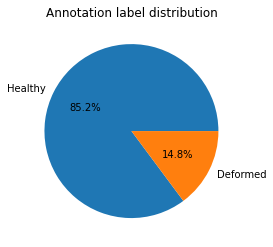

Counter({'Healthy': 339, 'Deformed': 59})


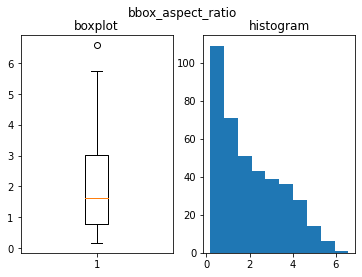

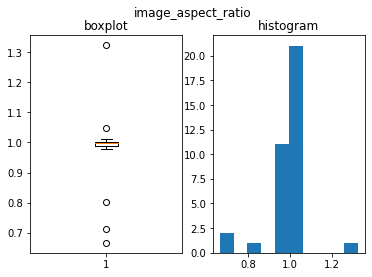

How many of the images contain at least one of the classes:


,Label,Amount,Precentage
0,Healthy,35,0.972222
1,Deformed,16,0.444444


In [4]:
name = "train"
df = dataset_to_df(name)

counts = collections.Counter(df["label"])
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%')
plt.title("Annotation label distribution")
plt.show()
print(counts)


plot_distributions(df["bbox_aspect_ratio"], "bbox_aspect_ratio")
plot_distributions(list(df.groupby("file_name").agg({"image_aspect_ratio": "mean"})["image_aspect_ratio"]), "image_aspect_ratio")

print("How many of the images contain at least one of the classes:")
how_many_images_contain_each_class_at_least_ones(df)

## Validation

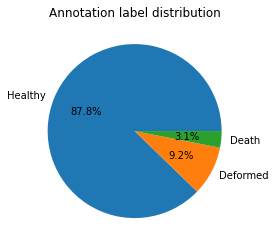

Counter({'Healthy': 86, 'Deformed': 9, 'Death': 3})


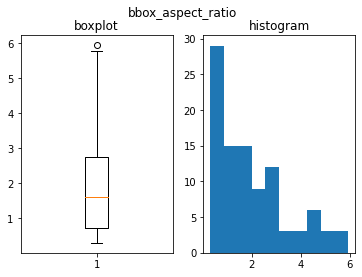

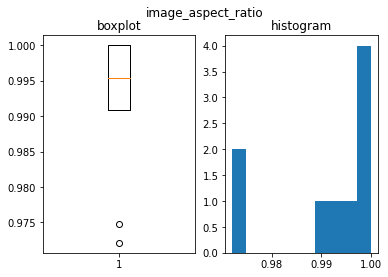

How many of the images contain at least one of the classes:


,Label,Amount,Precentage
0,Healthy,9,1.000000
1,Deformed,4,0.444444
2,Death,2,0.222222


In [5]:
name = "val"
df = dataset_to_df(name)

counts = collections.Counter(df["label"])
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%')
plt.title("Annotation label distribution")
plt.show()
print(counts)


plot_distributions(df["bbox_aspect_ratio"], "bbox_aspect_ratio")
plot_distributions(list(df.groupby("file_name").agg({"image_aspect_ratio": "mean"})["image_aspect_ratio"]), "image_aspect_ratio")

print("How many of the images contain at least one of the classes:")
how_many_images_contain_each_class_at_least_ones(df)

## Test

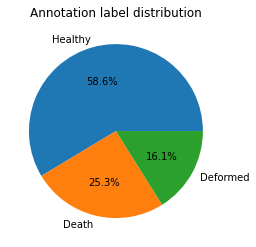

Counter({'Healthy': 51, 'Death': 22, 'Deformed': 14})


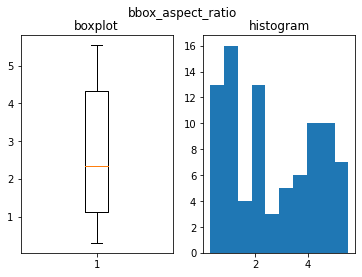

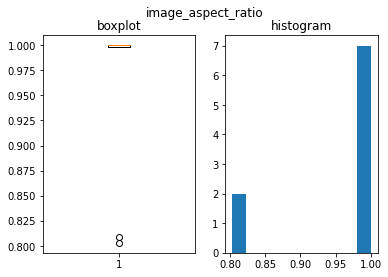

How many of the images contain at least one of the classes:


,Label,Amount,Precentage
0,Healthy,7,0.777778
1,Death,5,0.555556
2,Deformed,5,0.555556


In [6]:
name = "test"
df = dataset_to_df(name)

counts = collections.Counter(df["label"])
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%')
plt.title("Annotation label distribution")
plt.show()
print(counts)


plot_distributions(df["bbox_aspect_ratio"], "bbox_aspect_ratio")
plot_distributions(list(df.groupby("file_name").agg({"image_aspect_ratio": "mean"})["image_aspect_ratio"]), "image_aspect_ratio")

print("How many of the images contain at least one of the classes:")
how_many_images_contain_each_class_at_least_ones(df)

# Data visualization

In [7]:
def plot_dataset_dict(dataset_dict, meta_dataset, figsize=(10, 10)):
    image = read_image(dataset_dict["file_name"])
    
    visualizer = Visualizer(image[:, :, ::-1], metadata=meta_dataset, scale=0.5)
    out = visualizer.draw_dataset_dict(dataset_dict)
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image())
    plt.title(Path(dataset_dict['file_name']).name)
    plt.show()

## Training data

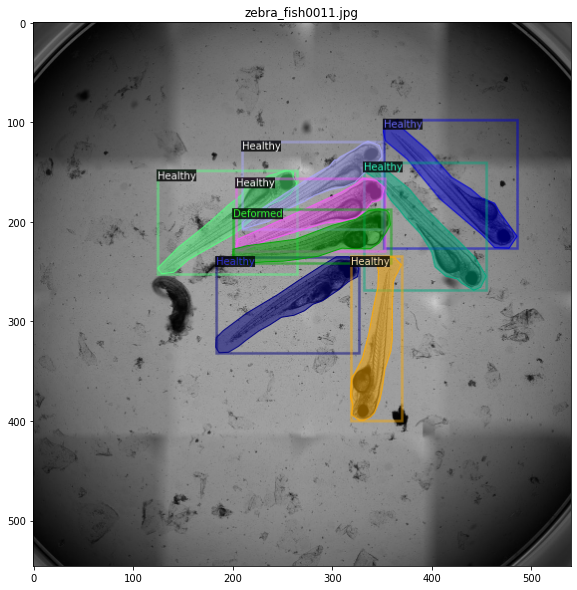

In [8]:
seed = 42
n_samples = 1
random.seed(seed)
name = "train"

dataset = DatasetCatalog.get(name)
meta_dataset = MetadataCatalog.get(name)

for dataset_dict in random.choices(dataset, k=n_samples):
    plot_dataset_dict(dataset_dict, meta_dataset)

## Validation dataset

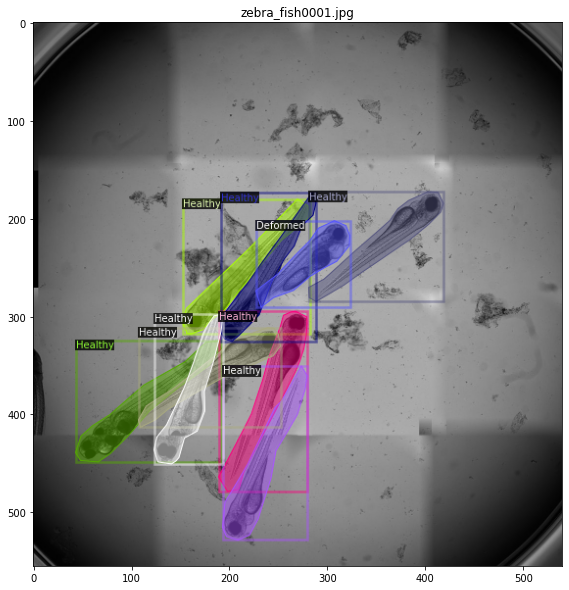

In [13]:
seed = 42
n_samples = 1
random.seed(seed)
name = "val"

dataset = DatasetCatalog.get(name)
meta_dataset = MetadataCatalog.get(name)

for dataset_dict in random.choices(dataset, k=n_samples):
    plot_dataset_dict(dataset_dict, meta_dataset)

## Test set

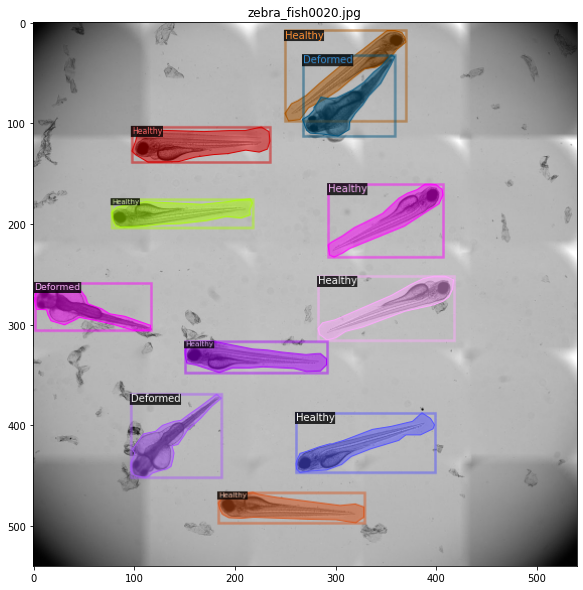

In [14]:
seed = 42
n_samples = 1
random.seed(seed)
name = "test"

dataset = DatasetCatalog.get(name)
meta_dataset = MetadataCatalog.get(name)

for dataset_dict in random.choices(dataset, k=n_samples):
    plot_dataset_dict(dataset_dict, meta_dataset)

# Data overlappath_other

These image are very similiar with HD=2
- /home/jordi/Documents/GitHub/zebra_fish/src/../dataset/test/zebra_fish0020.jpg
- /home/jordi/Documents/GitHub/zebra_fish/src/../dataset/test/zebra_fish0034.jpg


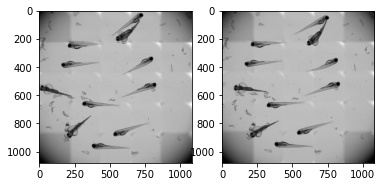

In [11]:
import shelve
import imagehash
from PIL import Image
import itertools

hamming_distance = 3

db = collections.defaultdict(list)
hash_path_tuples = []

for name in DatasetCatalog.list():
    for item in DatasetCatalog.get(name):
        path = Path(item["file_name"])
        image = Image.open(path)
        h = imagehash.dhash(image)
      
        hash_path_tuples.append((h, path))
        

        

for (h_one, path_one), (h_other, path_other) in itertools.combinations(hash_path_tuples, r=2):
    if h_one - h_other <= hamming_distance:
        print(f"These image are very similiar with HD={h_one - h_other }")
        print("-", path_one)
        print("-", path_other)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        ax1.imshow(read_image(path_one))
        ax2.imshow(read_image(path_other))
        plt.show()

    